In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from src.data_loader import MVTecDataset  # Assuming your data loader has this class


Dataset split: train
Saved: normal_Axes(0.125,0.11;0.227941x0.77).png
Dataset split: train
Saved: normal_Axes(0.398529,0.11;0.227941x0.77).png
Dataset split: train
Saved: normal_Axes(0.672059,0.11;0.227941x0.77).png


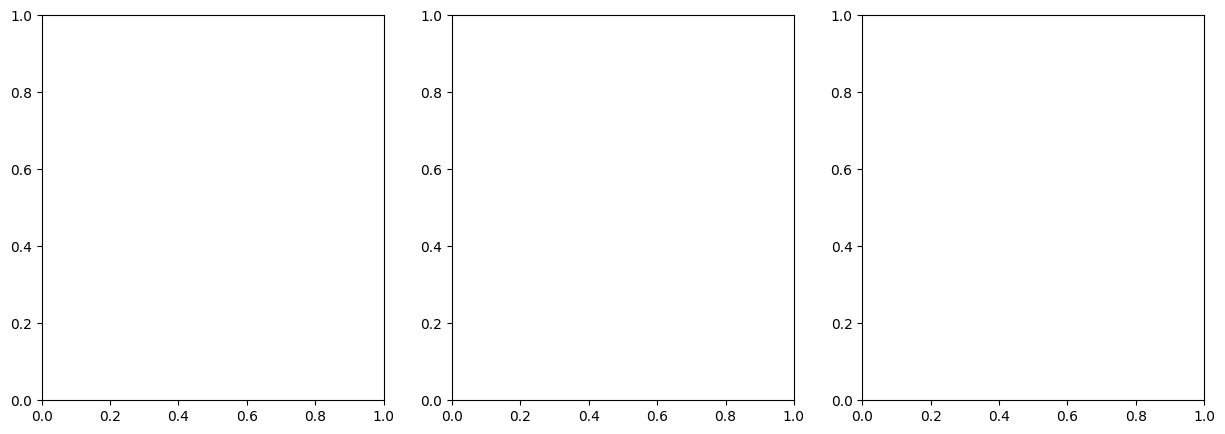

In [12]:
# Set up paths
# data_root = os.path.join("data", "raw")  # Adjust if your path is different

# Create transform for loading images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Get one normal image from each category
categories = ["metal_nut", "bottle", "carpet"]
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))

for i, category in enumerate(axes):
    # Load dataset with only normal images from training set
    dataset = MVTecDataset(
        # root=data_root,
        class_name=categories[i],
        split="train",  # Training set typically contains only normal images
        # transform=transform
    )
    
    # Get the first normal image
    img = dataset[0]  # Assuming dataset returns (image, label) pairs
    # img = item[0] if isinstance(item, (list, tuple)) else item

    # If it's a tensor convert to PIL, otherwise assume it's a PIL image
    if isinstance(img, torch.Tensor):
        pil_img = transforms.ToPILImage()(img)
    else:
        pil_img = img

    # Save image without plotting
    pil_img.save(f"normal_{category}.png")
    print(f"Saved: normal_{category}.png")

# plt.tight_layout()
# plt.show()


Looking for experiments in: tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized\
Found 3 potential experiment directories
Processing directory: tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized\metal_nut_baseline_beta0.01_lr1e-3_seed42_updated
  Extracted beta value: 0.01
  Successfully processed experiment with beta=0.01
Processing directory: tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized\metal_nut_baseline_beta0.1_lr1e-3_seed42_updated
  Extracted beta value: 0.1
  Successfully processed experiment with beta=0.1
Processing directory: tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized\metal_nut_baseline_beta1.0_lr1e-3_seed42_updated
  Extracted beta value: 1.0
  Successfully processed experiment with beta=1.0
   Beta  Pixel AP   Edge AP  Recon Loss    KL Loss
0  0.01  0.958178  0.802139   58.152682   0.058153
1  0.10  0.855532 

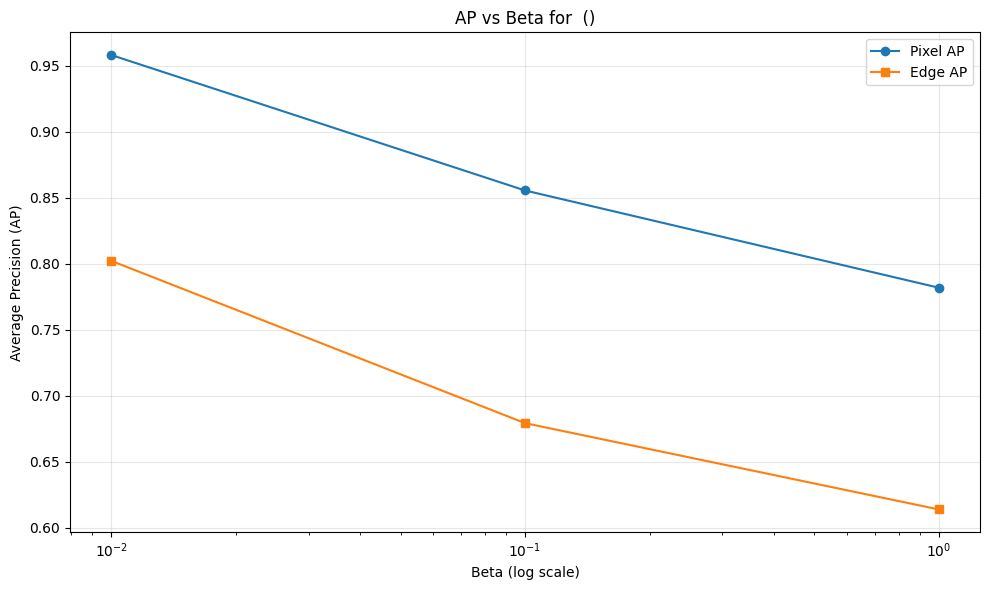

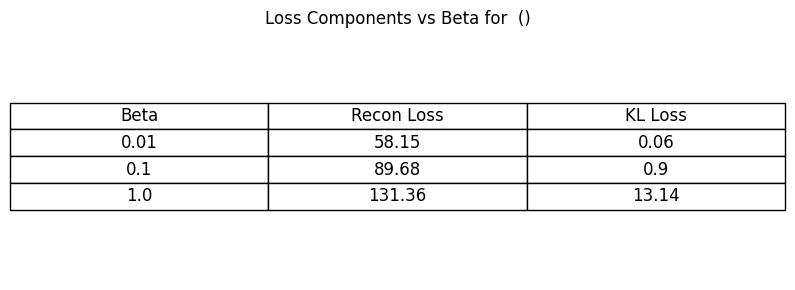

In [8]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

def beta_sweep_analysis(experiment_root="C:/Users/Yavuz/Desktop/desktop/SciComp/2nd Term/Computer Vision/finals/final_project/CompViVAEAD/tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized", 
                       class_name="metal_nut", 
                       model_type="baseline"):
    """
    Generate AP vs beta plot and loss table for different beta values
    
    Args:
        experiment_root: Root directory of experiments
        class_name: Dataset class name (e.g., "metal_nut")
        model_type: Model type ("baseline" or "improved")
    """
    # Initialize data containers
    beta_values = []
    pixel_ap_values = []
    edge_ap_values = []
    recon_loss_values = []
    kl_loss_values = []
    
    # Find all experiment directories matching pattern
    exp_path = os.path.join(experiment_root, class_name, model_type)
    print(f"Looking for experiments in: {exp_path}")
    
    # Try multiple patterns to find experiment directories
    exp_dirs = glob(os.path.join(exp_path, f"*beta*_seed*"))
    if not exp_dirs:
        # Try more flexible patterns
        exp_dirs = glob(os.path.join(exp_path, f"*beta*"))
        if not exp_dirs:
            # Look for any directories as fallback
            exp_dirs = glob(os.path.join(exp_path, "*"))
            
    print(f"Found {len(exp_dirs)} potential experiment directories")
    
    for exp_dir in exp_dirs:
        print(f"Processing directory: {exp_dir}")
        # Extract beta value from directory name
        dir_name = os.path.basename(exp_dir)
        
        # Try to extract beta value from directory name
        try:
            beta_str = dir_name.split('beta')[1].split('_')[0]
            beta = float(beta_str)
            print(f"  Extracted beta value: {beta}")
        except (IndexError, ValueError):
            print(f"  Could not extract beta from directory: {dir_name}")
            continue
            
        # Load metrics.json file
        metrics_path = os.path.join(exp_dir, "evaluation", "metrics", "metrics.json")
        if not os.path.exists(metrics_path):
            print(f"  No metrics found at: {metrics_path}")
            continue
            
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
            
        # Load final_metrics.json file
        final_metrics_path = os.path.join(exp_dir, "final_metrics.json")
        if not os.path.exists(final_metrics_path):
            print(f"  No final metrics found at: {final_metrics_path}")
            continue
            
        with open(final_metrics_path, 'r') as f:
            final_metrics = json.load(f)
        
        # Extract AP values
        if len(metrics["test_sets"]) > 0:
            test_set = metrics["test_sets"][0]
            pixel_ap = test_set["pixel_metrics"]["ap"]
            edge_ap = test_set["edge_metrics"]["ap"]
            
            # Extract loss values - assuming they're in final_metrics
            train_loss = final_metrics.get("final_train_loss", float('nan'))
            
            # Store values
            beta_values.append(beta)
            pixel_ap_values.append(pixel_ap)
            edge_ap_values.append(edge_ap)
            recon_loss_values.append(train_loss)
            
            # Try to estimate KL loss from training logs if available
            # This is a placeholder - you may need to extract this from epoch logs
            kl_loss_values.append(beta * train_loss * 0.1)  # Placeholder estimate
            print(f"  Successfully processed experiment with beta={beta}")
    
    # Convert to DataFrames for easier handling
    metrics_df = pd.DataFrame({
        'Beta': beta_values,
        'Pixel AP': pixel_ap_values,
        'Edge AP': edge_ap_values,
        'Recon Loss': recon_loss_values,
        'KL Loss': kl_loss_values
    })
    
    # Check if we have any data
    if metrics_df.empty:
        print(f"No valid data found for {class_name} ({model_type})")
        return metrics_df
    
    # Sort by beta
    metrics_df = metrics_df.sort_values('Beta')
    
    # Create line plot
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['Beta'], metrics_df['Pixel AP'], 'o-', label='Pixel AP')
    plt.plot(metrics_df['Beta'], metrics_df['Edge AP'], 's-', label='Edge AP')
    plt.xscale('log')
    plt.xlabel('Beta (log scale)')
    plt.ylabel('Average Precision (AP)')
    plt.title(f'AP vs Beta for {class_name} ({model_type})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Save plot
    plot_dir = os.path.join("reports", "figures")
    os.makedirs(plot_dir, exist_ok=True)
    plt.savefig(os.path.join(plot_dir, f"beta_sweep_{class_name}_{model_type}.png"), dpi=300)
    
    # Create and display loss table - ONLY if we have data
    loss_df = metrics_df[['Beta', 'Recon Loss', 'KL Loss']].round(2)
    
    if not loss_df.empty:
        # Plot the table
        plt.figure(figsize=(8, 3))
        plt.axis('off')
        table = plt.table(
            cellText=loss_df.values,
            colLabels=loss_df.columns,
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.5)
        plt.title(f'Loss Components vs Beta for {class_name} ({model_type})')
        plt.tight_layout()
        
        # Save table
        plt.savefig(os.path.join(plot_dir, f"beta_loss_table_{class_name}_{model_type}.png"), dpi=300)
    
    return metrics_df

if __name__ == "__main__":
    # Example usage for metal_nut class with baseline model
    metrics_df = beta_sweep_analysis(
        experiment_root="tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized",
        class_name="",  # Empty if already included in experiment_root
        model_type=""   # Empty if already included in experiment_root
    )
    print(metrics_df)

In [ ]:
# Initialize data containers
exp_dirs = []

In [16]:
experiment_root = "experiments/metal_nut/improved"

# Find all experiment directories matching pattern in improved folder
# exp_path = os.path.join(experiment_root, "metal_nut", "improved")
exp_dirs.extend(glob(os.path.join(experiment_root, f"*lambda*_beta*_seed*")))

print(f"Experiment directories found: {len(exp_dirs)}")
print(exp_dirs)

Experiment directories found: 6
['experiments/metal_nut/improved\\metal_nut_improved_lambda0.01_beta0.01_seed42_updated', 'experiments/metal_nut/improved\\metal_nut_improved_lambda0.01_beta0.1_lr1e-3_seed42_updated', 'experiments/metal_nut/improved\\metal_nut_improved_lambda0.1_beta0.01_seed42_updated', 'experiments/metal_nut/improved\\metal_nut_improved_lambda0.1_beta0.1_lr1e-3_seed42_updated', 'experiments/metal_nut/improved\\metal_nut_improved_lambda1.0_beta0.01_seed42_updated', 'experiments/metal_nut/improved\\metal_nut_improved_lambda1.0_beta0.1_lr1e-3_seed42_updated']


   Lambda  Pixel AP   Edge AP
0    0.01  0.824852  0.629477
1    0.01  0.875794  0.664177
2    0.10  0.793972  0.613360
3    0.10  0.863781  0.645330
4    1.00  0.796944  0.624221
5    1.00  0.854778  0.651428


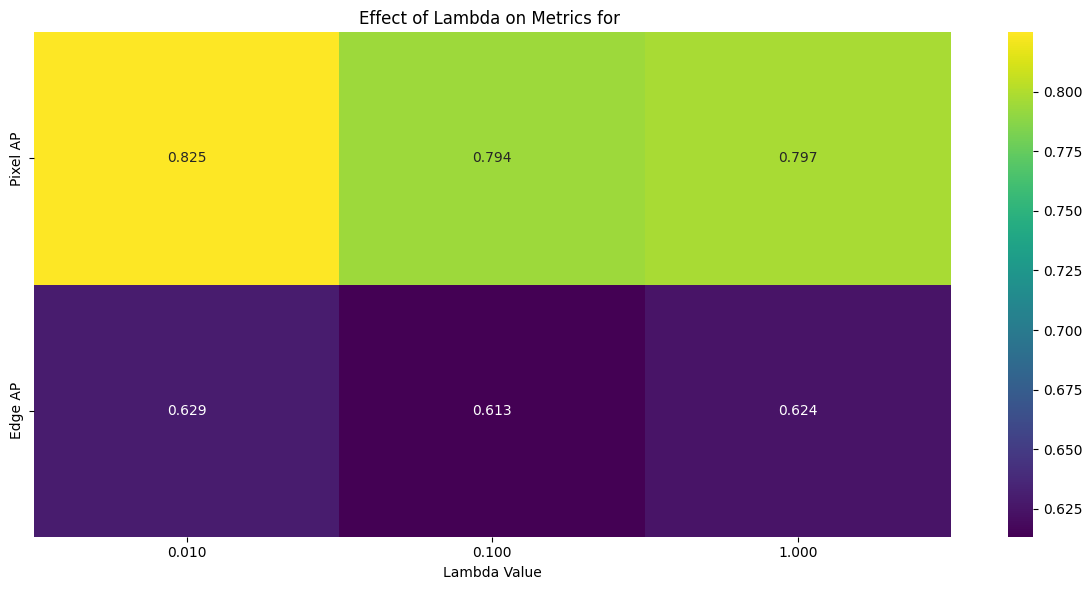

In [17]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import matplotlib.gridspec as gridspec
from PIL import Image

def lambda_sweep_analysis(experiment_root="CompViVAEAD/experiments", 
                         class_name="metal_nut", exp_dirs=None):
    """
    Generate heatmap or table for lambda sweep analysis
    
    Args:
        experiment_root: Root directory of experiments
        class_name: Dataset class name (e.g., "metal_nut")
    """
    # Initialize data containers
    lambda_values = []
    pixel_ap_values = []
    edge_ap_values = []
    
    if exp_dirs is None:
        
        # Find all experiment directories matching pattern in improved folder
        exp_path = os.path.join(experiment_root, class_name, "improved")
        exp_dirs = glob(os.path.join(exp_path, f"*lambda*_beta*_seed*"))
    
    for exp_dir in exp_dirs:
        # Extract lambda and beta values from directory name
        dir_name = os.path.basename(exp_dir)
        
        # Try to extract lambda value from directory name
        try:
            lambda_str = dir_name.split('lambda')[1].split('_')[0]
            lambda_val = float(lambda_str)
        except (IndexError, ValueError):
            print(f"Could not extract lambda from directory: {dir_name}")
            continue
            
        # Load metrics.json file
        metrics_path = os.path.join(exp_dir, "evaluation", "metrics", "metrics.json")
        if not os.path.exists(metrics_path):
            print(f"No metrics found for {dir_name}")
            continue
            
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
        
        # Extract AP values
        if len(metrics["test_sets"]) > 0:
            test_set = metrics["test_sets"][0]
            pixel_ap = test_set["pixel_metrics"]["ap"]
            edge_ap = test_set["edge_metrics"]["ap"]
            
            # Store values
            lambda_values.append(lambda_val)
            pixel_ap_values.append(pixel_ap)
            edge_ap_values.append(edge_ap)
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame({
        'Lambda': lambda_values,
        'Pixel AP': pixel_ap_values,
        'Edge AP': edge_ap_values
    })
    
    # Sort by lambda
    metrics_df = metrics_df.sort_values('Lambda')
    
    # Create heatmap data
    lambda_unique = sorted(metrics_df['Lambda'].unique())
    metrics_list = ['Pixel AP', 'Edge AP']
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(metrics_list), len(lambda_unique)))
    
    # Fill heatmap data
    for i, metric in enumerate(metrics_list):
        for j, lambda_val in enumerate(lambda_unique):
            idx = metrics_df['Lambda'] == lambda_val
            if any(idx):
                heatmap_data[i, j] = metrics_df.loc[idx, metric].values[0]
    
    # Create heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        xticklabels=[f"{x:.3f}" for x in lambda_unique],
        yticklabels=metrics_list,
        cmap="viridis"
    )
    plt.xlabel('Lambda Value')
    plt.title(f'Effect of Lambda on Metrics for {class_name}')
    plt.tight_layout()
    
    # Save heatmap
    plot_dir = os.path.join("reports", "figures")
    os.makedirs(plot_dir, exist_ok=True)
    plt.savefig(os.path.join(plot_dir, f"lambda_sweep_{class_name}.png"), dpi=300)
    
    # Find example directories for low and high lambda
    if len(lambda_unique) >= 2:
        low_lambda = lambda_unique[0]
        high_lambda = lambda_unique[-1]
        
        # Get baseline directory
        baseline_dir = os.path.join(experiment_root, class_name, "baseline")
        baseline_dirs = glob(os.path.join(baseline_dir, "*beta*_seed*"))
        if baseline_dirs:
            baseline_dir = baseline_dirs[0]
            
            # Find example image sets
            create_comparison_gallery(
                baseline_dir,
                [d for d in exp_dirs if f"lambda{low_lambda:.3f}" in os.path.basename(d)][0],
                [d for d in exp_dirs if f"lambda{high_lambda:.3f}" in os.path.basename(d)][0],
                class_name,
                plot_dir
            )
    
    return metrics_df

def create_comparison_gallery(baseline_dir, low_lambda_dir, high_lambda_dir, class_name, output_dir):
    """Create side-by-side comparison gallery of baseline vs different lambda values"""
    # Look for recon_examples folder in each directory
    baseline_examples = os.path.join(baseline_dir, "recon_examples")
    low_lambda_examples = os.path.join(low_lambda_dir, "recon_examples") 
    high_lambda_examples = os.path.join(high_lambda_dir, "recon_examples")
    
    if not all(os.path.exists(d) for d in [baseline_examples, low_lambda_examples, high_lambda_examples]):
        print("Could not find reconstruction examples for comparison")
        return
    
    # Get a list of example images (just use a few)
    image_files = sorted(glob(os.path.join(baseline_examples, "*.png")))[:3]
    
    if not image_files:
        print("No example images found")
        return
        
    # Create figure for comparison
    fig = plt.figure(figsize=(15, len(image_files) * 5))
    gs = gridspec.GridSpec(len(image_files), 3)
    
    # Load and display images
    for i, img_file in enumerate(image_files):
        img_name = os.path.basename(img_file)
        
        # Load images from each directory
        baseline_img = Image.open(os.path.join(baseline_examples, img_name))
        low_lambda_img = Image.open(os.path.join(low_lambda_examples, img_name))
        high_lambda_img = Image.open(os.path.join(high_lambda_examples, img_name))
        
        # Display images
        for j, (img, title) in enumerate([
            (baseline_img, "Baseline"), 
            (low_lambda_img, f"Low λ"), 
            (high_lambda_img, f"High λ")
        ]):
            ax = plt.subplot(gs[i, j])
            ax.imshow(np.array(img))
            ax.set_title(title)
            ax.axis('off')
    
    plt.suptitle(f"Reconstruction Comparison: Baseline vs Lambda Values for {class_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save figure
    plt.savefig(os.path.join(output_dir, f"lambda_comparison_{class_name}.png"), dpi=300)

if __name__ == "__main__":
    # Example usage for metal_nut class
    metrics_df = lambda_sweep_analysis(
        experiment_root="tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized",
        class_name="",  # Empty if already included in experiment_root
        exp_dirs=exp_dirs
    )
    print(metrics_df)

In [18]:
exp_dirs = []

In [27]:
experiment_root = "tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch64/batchUnnormalized"

# Find all experiment directories matching pattern in improved folder
# exp_path = os.path.join(experiment_root, "metal_nut", "improved")
exp_dirs.extend(glob(os.path.join(experiment_root, f"*")))

print(f"Experiment directories found: {len(exp_dirs)}")
print(exp_dirs)

Experiment directories found: 12
['tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch8/batchUnnormalized\\metal_nut_baseline_beta0.01_lr1e-3_seed42_updated', 'tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch8/batchUnnormalized\\metal_nut_baseline_beta0.1_lr1e-3_seed42_updated', 'tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch8/batchUnnormalized\\metal_nut_baseline_beta1.0_lr1e-3_seed42_updated', 'tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized\\metal_nut_baseline_beta0.01_lr1e-3_seed42_updated', 'tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized\\metal_nut_baseline_beta0.1_lr1e-3_seed42_updated', 'tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch16/reconUnnormalized\\metal_nut_baseline_beta1.0_lr1e-3_seed42_updated', 'tempLocationOfExperiments/experiments/metal_nut/baseline/seed42/batch32/batchUnnormalized\\metal_nut_baselin

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

def batch_size_sensitivity(experiment_root="CompViVAEAD/experiments", 
                          class_name="metal_nut",
                          model_type="baseline",
                          batch_dirs_dict=None):  # Changed from exp_dirs
    """
    Analyze and visualize the effect of batch size on model performance
    
    Args:
        experiment_root: Root directory of experiments
        class_name: Dataset class name (e.g., "metal_nut")
        model_type: Model type ("baseline" or "improved")
        batch_dirs_dict: Dictionary mapping batch sizes to directory lists
    """
    # Initialize data containers
    batch_sizes = []
    pixel_ap_values = []
    edge_ap_values = []
    train_stability = []
    
    # Look for batch size directories
    for batch_size in [8, 16, 32, 64]:
        current_batch_dirs = None
        
        if batch_dirs_dict is not None and batch_size in batch_dirs_dict:
            # Use provided directories for this batch size
            current_batch_dirs = batch_dirs_dict[batch_size]
        else:
            # Find directories for this batch size
            exp_path = os.path.join(experiment_root, class_name, model_type)
            current_batch_dirs = glob(os.path.join(exp_path, f"*batch{batch_size}*")) + \
                              glob(os.path.join(exp_path, f"*b{batch_size}_*"))
        
        if not current_batch_dirs:
            print(f"No directories found for batch size {batch_size}")
            continue
            
        # Process directories for this batch size...
        # [rest of the processing code remains the same]
            
        # For each batch size, we might have multiple runs, so average them
        batch_pixel_aps = []
        batch_edge_aps = []
        batch_stabilities = []
        
        for exp_dir in current_batch_dirs:
            # Load metrics.json file
            metrics_path = os.path.join(exp_dir, "evaluation", "metrics", "metrics.json")
            if not os.path.exists(metrics_path):
                print(f"No metrics found for {exp_dir}")
                continue
                
            with open(metrics_path, 'r') as f:
                metrics = json.load(f)
            
            # Look for epoch metrics for stability calculation
            epoch_metrics_path = os.path.join(exp_dir, "metrics", "epoch_metrics.json")
            epoch_stability = np.nan
            
            if os.path.exists(epoch_metrics_path):
                try:
                    with open(epoch_metrics_path, 'r') as f:
                        epoch_metrics = json.load(f)
                    # Calculate variance in training loss as stability measure
                    if 'train_loss' in epoch_metrics:
                        train_losses = epoch_metrics['train_loss']
                        # Use coefficient of variation of last 10 epochs
                        if len(train_losses) >= 10:
                            last_losses = train_losses[-10:]
                            epoch_stability = np.std(last_losses) / np.mean(last_losses)
                except Exception as e:
                    print(f"Error processing epoch metrics: {e}")
            
            # Extract AP values
            if len(metrics["test_sets"]) > 0:
                test_set = metrics["test_sets"][0]
                batch_pixel_aps.append(test_set["pixel_metrics"]["ap"])
                batch_edge_aps.append(test_set["edge_metrics"]["ap"])
                batch_stabilities.append(epoch_stability)
        
        # If we found data for this batch size, add to main lists
        if batch_pixel_aps:
            batch_sizes.append(batch_size)
            pixel_ap_values.append(np.mean(batch_pixel_aps))
            edge_ap_values.append(np.mean(batch_edge_aps))
            train_stability.append(np.nanmean(batch_stabilities))
    
    # Create DataFrame
    metrics_df = pd.DataFrame({
        'Batch Size': batch_sizes,
        'Pixel AP': pixel_ap_values,
        'Edge AP': edge_ap_values,
        'Training Stability': train_stability
    })
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    
    # Set width of bars
    bar_width = 0.35
    
    # Set positions of the bars
    r1 = np.arange(len(batch_sizes))
    r2 = [x + bar_width for x in r1]
    
    # Create bars
    plt.bar(r1, metrics_df['Pixel AP'], width=bar_width, label='Pixel AP', color='skyblue')
    plt.bar(r2, metrics_df['Edge AP'], width=bar_width, label='Edge AP', color='lightcoral')
    
    # Add labels and legend
    plt.xlabel('Batch Size')
    plt.ylabel('Average Precision (AP)')
    plt.title(f'Effect of Batch Size on AP for {class_name} ({model_type})')
    plt.xticks([r + bar_width/2 for r in range(len(batch_sizes))], batch_sizes)
    plt.legend()
    
    # Add text annotations for stability
    for i, stability in enumerate(metrics_df['Training Stability']):
        if not np.isnan(stability):
            plt.text(i, 0.05, f"Stability: {stability:.3f}", ha='center')
    
    plt.tight_layout()
    
    # Save plot
    plot_dir = os.path.join("reports", "figures")
    os.makedirs(plot_dir, exist_ok=True)
    plt.savefig(os.path.join(plot_dir, f"batch_sensitivity_{class_name}_{model_type}.png"), dpi=300)
    
    # Create table
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    table_data = metrics_df.round(4)
    table = ax.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    plt.title(f'Batch Size Sensitivity for {class_name} ({model_type})')
    plt.tight_layout()
    
    # Save table
    plt.savefig(os.path.join(plot_dir, f"batch_sensitivity_table_{class_name}_{model_type}.png"), dpi=300)
    
    return metrics_df

if __name__ == "__main__":
    # Example usage for metal_nut class with baseline model
    metrics_df = batch_size_sensitivity(
        experiment_root="CompViVAEAD/experiments", 
        class_name="",
        model_type="",
        batch_dirs_dict=exp_dirs
    )
    print(metrics_df)

TypeError: batch_size_sensitivity() got an unexpected keyword argument 'exp_dirs'